# 1. Import the necessary libraries

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from gensim.models import Word2Vec, KeyedVectors
import numpy as np
import pickle
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
from keras.utils import to_categorical
from keras.utils import plot_model
from pyvi import ViTokenizer
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve,auc

# 2. Data preprocessing

In [9]:
def ReadData(path):
    df = pd.read_csv(path,encoding='utf-8')
    return df['comment'], df['label']

In [10]:
X_train, y_train = ReadData("G:\\VietNamese-Sentiment-Analyst\\data\\data_processed\\train_processed.csv")
X_test, y_test= ReadData("G:\\VietNamese-Sentiment-Analyst\\data\\data_processed\\test_processsed.csv")

In [11]:
print(f"X_Train size:{X_train.shape}")
print(f"y_train size {y_train.shape}")

X_Train size:(7786,)
y_train size (7786,)


In [12]:
# Hàm Tokenizer
def wordseparation(comment):
    return [review.split() for review in comment]

In [13]:
X_train = wordseparation(X_train)
X_test = wordseparation(X_test)
print(f"X_Train: {X_train[0:2]}")
print(f"X_test: {X_test[0:2]}")

X_Train: [['pin', 'kém', 'còn', 'miễn', 'chê', 'mua', '832019', 'tình_trạng', 'pin', 'còn', '88', 'ai', 'giống', 'tôi'], ['sao', 'gọi', 'điện_thoại', 'màn_hình', 'chấm', 'nhỏ', 'nháy', 'gần', 'camera', 'vậylúc']]
X_test: [['điện', 'thoải', 'ổn', 'facelock', 'cực', 'nhanh', 'vân', 'tay', 'ôk', 'màn_hình', 'lớn', 'pin', 'trâu', 'liên_quân', 'zalo', 'youtube', 'một', 'ngày', 'mất', 'khoảng', '45', 'tuy', 'chip', '439', 'mượt', 'đa_nhiệm', 'khá', 'ổn'], ['mình', 'mới', 'mua', 'vivo91c', 'tải', 'ứng_dụng', 'games', 'nhanh', 'hài_lòng', 'cài', 'hình', 'nền', 'khóa', 'màn_hình', 'hay', 'mình', 'biết', 'hết', 'chức_năng', 'nó', 'tư_vấn', 'viên', 'nhiệt_tình']]


In [7]:
model_wordembedding = Word2Vec(sentences=X_train, vector_size=20, window=5, min_count=0, workers=4, sg=1)
model_wordembedding.wv.save("G:\\VietNamese-Sentiment-Analyst\\model\\word.model")

Kích thước vector ở đây là 20 chiều, ngữ cảnh là 5 (Xem xét 5 từ xung quanh để dự đoán từ đó), Skip-gram ở đây là 1 

In [14]:
# Load Model_Word2Vec
model_embedding = KeyedVectors.load('G:\\VietNamese-Sentiment-Analyst\\model\\word.model')
num_words = len(model_embedding.index_to_key)
print("Number of Words:", num_words)
print("Vector:", model_embedding.get_vector('điện_thoại'))

Number of Words: 11562
Vector: [ 0.09783211 -0.4998802   1.0074297   0.50004095 -0.06867395 -0.03650548
 -0.15354915  0.557026   -1.134267   -0.0805711   0.54981726 -0.33962223
 -0.1018343  -0.05006189  0.8966446   0.23283117  1.2300501  -0.21519509
 -0.50342035 -0.70583665]


In [15]:
# Lấy danh sách các vectơ từ
vectors = [model_embedding.get_vector(word) for word in model_embedding.index_to_key]
vectors_array = np.array(vectors)
# Giảm chiều dữ liệu từ 20 chiều xuống còn 2 chiều bằng t-SNE
tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(vectors_array)
print(vectors_2d[0:2])

[[86.00822  20.307539]
 [85.269295 21.133938]]


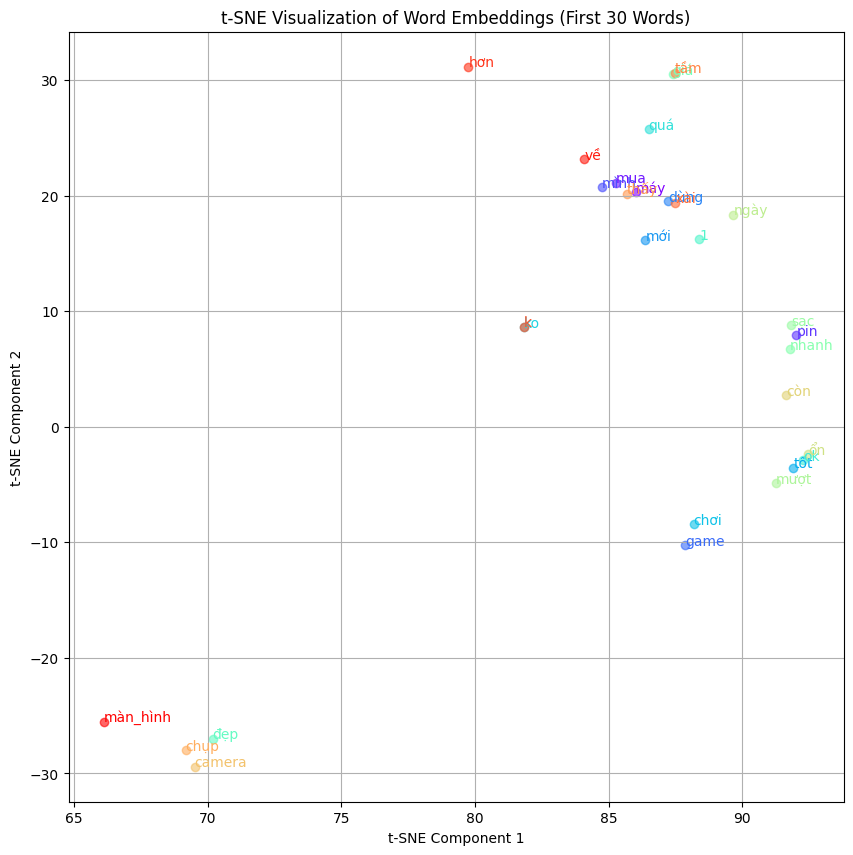

In [16]:
# Trực quan hóa các vectơ từ
plt.figure(figsize=(10, 10))
num_words = 30
# Màu cho mỗi từ
colors = plt.cm.rainbow(np.linspace(0, 1, num_words))

# Vẽ các điểm dữ liệu (từ) với màu khác nhau
for i, word in enumerate(model_embedding.index_to_key[:num_words]):  
    plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1], marker='o', color=colors[i], alpha=0.6)
    plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=10, color=colors[i])

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Word Embeddings (First 30 Words)')
plt.grid(True)
plt.show()

In [17]:
# Tạo bộ từ điển (dictionary) 
corpus = model_embedding.key_to_index

In [18]:
len(corpus)

11562

In [19]:
# Kiểm tra độ dài của câu trong data
max_sequence = max([len(seq) for seq in X_train])
max_sequence_t = max ([len(seq) for seq in X_test ])
print(max_sequence)
print(max_sequence_t)

128
131


In [20]:
# Chuyển đổi từ thành không gian vectơ và padding
def comment_embedding(comment):
    # Khởi tạo ma trận với kích thước (131, 20)
    matrix = np.zeros((131, 20))
    for i, word in enumerate(comment): # Chỉ lấy tối đa 131 từ
            if word in model_embedding:
                matrix[i] = model_embedding.get_vector(word)
    return matrix

In [ ]:
def Padding(Vi):
    vi_sequence =  X_train_corpus.texts_to_sequences(Vi)
    vi_sequence = pad_sequences(vi_sequence,maxlen = max_sentence_Xtest,padding='pre')
    return vi_sequence

In [21]:
train_data = []
test_data =[]
for x in tqdm(X_train):
    train_data.append(comment_embedding(x))
for y in tqdm(X_test): 
    test_data.append(comment_embedding(y))
test_data=np.array(test_data)
train_data=np.array(train_data)

100%|██████████| 2224/2224 [00:00<00:00, 30494.26it/s]


In [22]:
train_data[0]

array([[-0.56738466,  0.09404507,  0.67392409, ..., -0.15164639,
        -0.32673281, -0.19774757],
       [ 0.10398982, -0.50788951,  0.63008243, ...,  0.83142143,
        -0.65689021, -0.79846174],
       [-0.55588371,  0.02647388,  0.72576004, ...,  0.05811656,
        -0.17380881, -0.66790909],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [23]:
train_data.shape

(7786, 131, 20)

In [24]:
label_encoder = LabelEncoder()
# Mã hóa các nhãn văn bản thành các giá trị số
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
print(y_train_encoded[0:3])

[1 0 1]


In [25]:
# Biểu diễn nhãn dưới dạng one-hot vector
y_train_onehot = to_categorical(y_train_encoded)
print(y_train_onehot[0:3])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [26]:
y_train_onehot.shape

(7786, 3)

In [27]:
# Đếm số lượng mẫu trong mỗi lớp
class_counts = np.sum(y_train_onehot, axis=0)

print(class_counts)

[2966.  812. 4008.]


# 3. Build Model from scrath

## Hybird CNN + LSTM

In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Flatten, BatchNormalization, MaxPooling2D, Conv2D, Embedding, Conv1D, Dense, GlobalMaxPooling1D, Dropout, Bidirectional, LSTM, GRU, Input, MaxPooling1D, LayerNormalization # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from keras.callbacks import EarlyStopping

In [105]:
filter_sizes =(2,17)
dropout_rate = 0.3
# embedding_size=20
num_lstm_unit = 7
pool_size=(3, 2)
strides=(3, 2)

In [106]:
train_data.shape[0]

7786

In [107]:
X_train = train_data.reshape(train_data.shape[0], 131, 20, 1).astype('float32')

In [133]:
# Define the model
model = Sequential()
# Add a convolutional layer
model.add(Input(shape = (131, 20, 1)))
model.add(Conv2D(2, filter_sizes, activation='relu', name='convolution_layer'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size, strides, name='max_pooling'))
model.add(TimeDistributed(Flatten()))
model.add(Dropout(dropout_rate, name='dropout_layer1'))
model.add(LSTM(num_lstm_unit, return_sequences=True,name='LSTM_layer1'))
model.add(Dropout(dropout_rate, name='dropout_layer2'))
model.add(LSTM(num_lstm_unit, name='LSTM_layer2'))
model.add(Dense(3, activation='softmax'))

In [134]:
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convolution_layer (Conv2D)      │ (None, 130, 4, 2)      │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 130, 4, 2)      │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling (MaxPooling2D)      │ (None, 43, 2, 2)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 43, 4)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer1 (Dropout)        │ (None, 43, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_layer1 (LSTM)              │ (None, 43, 7)          │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer2 (Dropout)        │ (None, 43, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_layer2 (LSTM)              │ (None, 7)              │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 858 (3.35 KB)

 Trainable params: 854 (3.34 KB)

 Non-trainable params: 4 (16.00 B)

In [111]:
early_stopping_callback = EarlyStopping(monitor='val_loss',  patience=35, restore_best_weights=True)
history=model.fit(
    X_train,
    y_train_onehot,
    verbose=1,
    epochs=3,
    validation_split=0.2,
    batch_size=64,
    callbacks=[early_stopping_callback] 
)

Epoch 1/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.5213 - loss: 0.9462 - val_accuracy: 0.5180 - val_loss: 0.9255
Epoch 2/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5018 - loss: 0.9587 - val_accuracy: 0.5180 - val_loss: 0.9253
Epoch 3/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5192 - loss: 0.9430 - val_accuracy: 0.5180 - val_loss: 0.9261


In [25]:
model.save('G:\\VietNamese-Sentiment-Analyst\\model\\model_hybrid_cnn_lstm_sentiment.h5')

In [26]:
with open('G:\\VietNamese-Sentiment-Analyst\\history\\history_hybrid_cnn_lstm.pkl', 'wb') as file:
    pickle.dump(history.history, file)

## Hybird CNN + BiLSTM

In [112]:
x_train = train_data.reshape(train_data.shape[0], 131, 20).astype('float32')

In [113]:
def generate_model():
    dropout_threshold = 0.2
    input_dim = 11562  # Kích thước từ điển (số từ)
    output_dim = 20    # Kích thước của vector embedding
    input_length = 131 # Chiều dài của chuỗi đầu vào

    initializer = tf.keras.initializers.GlorotNormal()

    # Đầu vào với kích thước (None, 131, 20)
    input_layer = Input(shape=(input_length, output_dim))

    # Model CNN
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(input_layer)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(cnn_feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    # Model Bidirectional LSTM
    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer))(input_layer)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

    # Model Bidirectional GRU
    bi_gru_feature = Bidirectional(GRU(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer))(bi_lstm_feature)
    bi_gru_feature = MaxPooling1D()(bi_gru_feature)
    bi_gru_feature = LayerNormalization()(bi_gru_feature)

    # Kết hợp CNN + Bi_LSTM + Bi_GRU
    combine_feature = tf.keras.layers.Concatenate()([cnn_feature, bi_gru_feature])
    combine_feature = GlobalMaxPooling1D()(combine_feature)
    combine_feature = LayerNormalization()(combine_feature)

    # Fully connected
    classifier = Dense(64, activation='relu')(combine_feature)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(32, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(16, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(8, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)

    model = tf.keras.Model(inputs=input_layer, outputs=classifier)
    return model


In [114]:
model = generate_model()
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 131, 20)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 131, 32)   │      1,952 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 65, 32)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 131, 64)   │     13,568 │ input_layer_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 65, 32)    │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 65, 64)    │          0 │ bidirectional[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 65, 32)    │      3,104 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 65, 64)    │        128 │ max_pooling1d_2[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 32, 32)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 65, 64)    │     18,816 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 32, 32)    │         64 │ max_pooling1d_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 32, 64)    │          0 │ bidirectional_1[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32)    │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 64)    │        128 │ max_pooling1d_3[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 96)    │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 96)        │          0 │ concatenate[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 96)        │        192 │ global_max_pooli… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      6,208 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 46,931 (183.32 KB)

 Trainable params: 46,931 (183.32 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history = model.fit(
    x_train,
    y_train_onehot,
    verbose=1,
    epochs=200,
    validation_split=0.2,
    batch_size=64,
    callbacks=[early_stopping_callback]
)

Epoch 1/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.4618 - loss: 1.0375 - val_accuracy: 0.7888 - val_loss: 0.6556
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.7206 - loss: 0.7611 - val_accuracy: 0.8036 - val_loss: 0.5533
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.7505 - loss: 0.6905 - val_accuracy: 0.8004 - val_loss: 0.5510
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.7600 - loss: 0.6613 - val_accuracy: 0.8087 - val_loss: 0.5167
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.7781 - loss: 0.6279 - val_accuracy: 0.8113 - val_loss: 0.5081
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.7862 - loss: 0.6115 - val_accuracy: 0.8145 - val_loss: 0.5109
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.7844 - loss: 0.6142 - val_accuracy: 0.8100 - val_loss: 0.5102
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.7909 - loss: 0.5884 - 

In [31]:
model.save('G:\\VietNamese-Sentiment-Analyst\\model\\model_hybrid_cnn_bilstm_sentiment.h5')

In [32]:
with open('G:\\VietNamese-Sentiment-Analyst\\history\\history_cnn_bilstm.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# 4. Evaluation test dataset

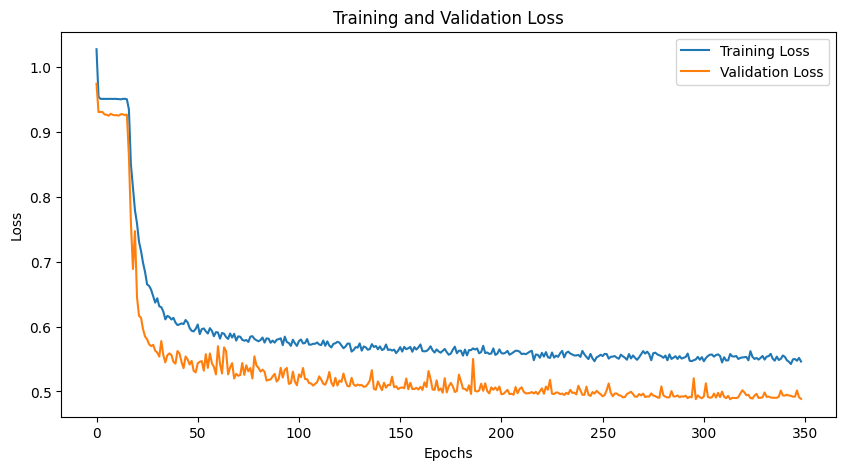

In [35]:
with open('G:\\VietNamese-Sentiment-Analyst\\history\\history_hybrid_cnn_lstm.pkl', 'rb') as file:
    history_lstm = pickle.load(file)
plt.figure(figsize=(10, 5))
plt.plot(history_lstm ['loss'], label='Training Loss')
plt.plot(history_lstm ['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

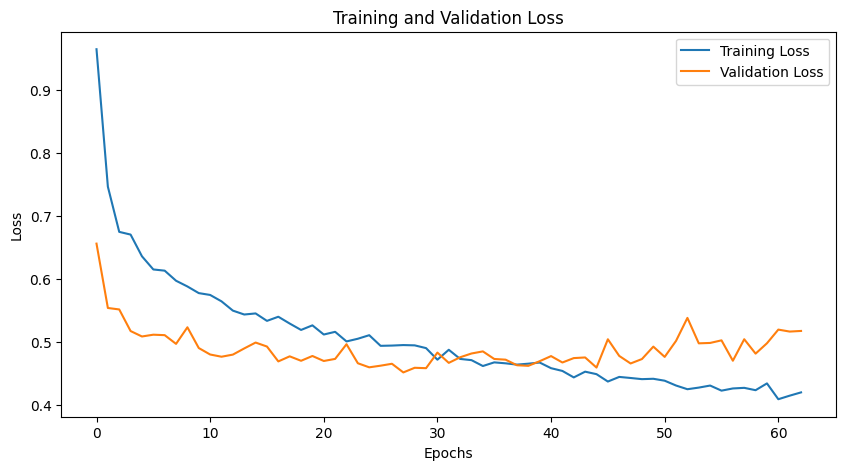

In [36]:
with open('G:\\VietNamese-Sentiment-Analyst\\history\\history_cnn_bilstm.pkl', 'rb') as file:
    history_lstm = pickle.load(file)
plt.figure(figsize=(10, 5))
plt.plot(history_lstm ['loss'], label='Training Loss')
plt.plot(history_lstm ['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [64]:
model_sentiment = load_model("G:\VietNamese-Sentiment-Analyst\model\model_hybrid_cnn_bilstm_sentiment.h5")

<>:1: SyntaxWarning: invalid escape sequence '\V'
<>:1: SyntaxWarning: invalid escape sequence '\V'
C:\Users\HP\AppData\Local\Temp\ipykernel_16548\554424254.py:1: SyntaxWarning: invalid escape sequence '\V'
  model_sentiment = load_model("G:\VietNamese-Sentiment-Analyst\model\model_hybrid_cnn_bilstm_sentiment.h5")


In [65]:
# Importing classification report and confussion matrix
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def confusion(y_test, y_pred):
    sns.set_theme(style= "whitegrid")
    plt.rcParams["figure.figsize"] = [5,3]
    plt.rcParams["figure.autolayout"] = True
    data = confusion_matrix(y_test,y_pred)
    df_cm = pd.DataFrame(data)
    df_cm.index.name = "Actual"
    df_cm.columns.name = "Predicted"
    cm = sns.heatmap(df_cm,annot=True, fmt="g")
    cm.plot()

In [66]:
result = model_sentiment.predict(test_data)

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


In [67]:
predict_labels = np.argmax(result,axis=1)
print(predict_labels[0:10])
# Decode the predicted labels
predicted_labels_decoded = label_encoder.inverse_transform(predict_labels)
print(predicted_labels_decoded[0:10])

[0 0 0 0 0 0 2 2 2 0]
['Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Positive' 'Positive' 'Positive' 'Negative']


In [68]:
from Preprocessing import remove_punctuation, remove_stopword, remove_repeated_words

In [60]:
def Preprocessing(comment):
    comment = remove_punctuation(comment.lower())
    comment = ViTokenizer.tokenize(comment)
    comment = remove_stopword(comment)
    comment = [remove_repeated_words(comment)]
    comment = wordseparation(comment)
    comment = np.expand_dims(comment_embedding(comment[0]),axis=0)
    return comment

In [69]:
comment = "Máy thiết kế quá đẹp ,dùng dk mấy hôm r thấy máy vẫn ổn ,tiếc là pin tụt quá nhanh ,pin sạc thì nhanh nóng 😌"
comment_preprocessed = Preprocessing(comment)
result_one = model_sentiment.predict(comment_preprocessed)
result_one = np.argmax(result_one,axis=1)
# Decode the predicted labels
print(label_encoder.inverse_transform(result_one))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
['Negative']


              precision    recall  f1-score   support

           0       0.50      0.95      0.66       894
           1       0.00      0.00      0.00       221
           2       0.89      0.42      0.57      1109

    accuracy                           0.59      2224
   macro avg       0.46      0.46      0.41      2224
weighted avg       0.65      0.59      0.55      2224



C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

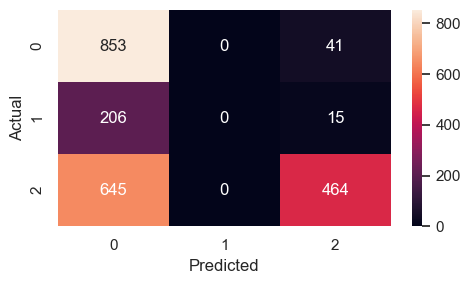

In [70]:
print(classification_report(y_test_encoded, predict_labels))
confusion(y_test_encoded, predict_labels)

In [71]:
accuracy_test = accuracy_score(y_test_encoded, predict_labels)
print(f'Accuracy: {accuracy_test:.4f}')
precision = precision_score(y_test_encoded, predict_labels, average='weighted')
print(f"Precision: {precision:.4f}")

recall = recall_score(y_test_encoded, predict_labels, average='weighted')
print(f"Recall: {recall:.4f}")

f1score = f1_score(y_test_encoded, predict_labels, average='weighted')
print(f"F1-score: {f1score}")

Accuracy: 0.5922
Precision: 0.6462
Recall: 0.5922
F1-score: 0.548031610310746


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
